Проект e-commerce: вариант 1 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. 
Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Описание полей таблиц

olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id               —  позаказный идентификатор пользователя (аналог номера паспорта)
customer_unique_id        —  уникальный идентификатор пользователя
customer_zip_code_prefix  —  почтовый индекс пользователя
customer_city             —  город доставки пользователя
customer_state            —  штат доставки пользователя


olist_orders_dataset.csv —  таблица заказов

order_id                      —  уникальный идентификатор заказа (номер чека)
customer_id                   —  позаказный идентификатор пользователя (аналог номера паспорта)
order_status                  —  статус заказа
order_purchase_timestamp      —  время создания заказа
order_approved_at             —  время подтверждения оплаты заказа
order_delivered_carrier_date  —  время передачи заказа в логистическую службу
order_delivered_customer_date —  время доставки заказа
order_estimated_delivery_date —  обещанная дата доставки


olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id            —  уникальный идентификатор заказа (номер чека)
order_item_id       —  идентификатор товара внутри одного заказа
product_id          —  ид товара (аналог штрихкода)
seller_id           —  ид производителя товара
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
price               —  цена за единицу товара
freight_value       —  вес товара


— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created     —  создан
approved    —  подтверждён
invoiced    —  выставлен счёт
processing  —  в процессе сборки заказа
shipped     —  отгружен со склада
delivered   —  доставлен пользователю
unavailable —  недоступен
canceled    —  отменён

In [2]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [3]:
# создаем ссылку для скачивания с Яндекс диска
url = 'https://getfile.dokpub.com/yandex/get/'

url_customer = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
url_orders   = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
url_order    = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [4]:
# читаем ссылки в переменные
olist_customers_datase    = pd.read_csv(url + url_customer)  
olist_orders_dataset      = pd.read_csv(url + url_orders, parse_dates=['order_purchase_timestamp', 
                                                                      'order_approved_at',
                                                                      'order_delivered_carrier_date',
                                                                      'order_delivered_customer_date',
                                                                      'order_estimated_delivery_date'])  
olist_order_items_dataset = pd.read_csv(url + url_order, parse_dates=['shipping_limit_date'])  

In [5]:
# смотрим структуру
olist_customers_datase.head(1)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   

   customer_zip_code_prefix customer_city customer_state  
0                     14409        franca             SP

In [6]:
olist_orders_dataset.head(1)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   

  order_estimated_delivery_date  
0                    2017-10-18

In [7]:
olist_order_items_dataset.head(1)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   

  shipping_limit_date  price  freight_value  
0 2017-09-19 09:45:35   58.9          13.29

---

1. Сколько у нас пользователей, которые совершили покупку только один раз? 

In [8]:
olist_customers_datase.shape

(99441, 5)

In [9]:
olist_orders_dataset.shape

(99441, 8)

In [10]:
# объединяем таблицы заказов и уникальных пользователей
customers_orders = olist_customers_datase.merge (olist_orders_dataset, on = 'customer_id')

In [11]:
# совершонной покупкой считаем когда по заказу произошла оплата. 
customers_orders_count = customers_orders.query ('order_approved_at.notna()') \
    .groupby ('customer_unique_id', as_index=False) \
    .agg ({'order_id' : 'count'})
customers_orders_count.query('order_id =="1"').shape[0]

93049

93049 пользователей, которые совершили покупку только один раз

In [12]:
# так же нужно проверить случаи когда даты оплаты нет, но статус заказа - delivered   —  доставлен пользователю 
# возможно проблема в логировании данных
customers_orders.query ('order_approved_at.isna()') \
    .groupby ('order_status', as_index=False) \
    .agg ({'order_id' : 'count'})

order_status  order_id
0     canceled       141
1      created         5
2    delivered        14

---

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [13]:
# отбираем недоставленные заказы по статусу: unavailable —  недоступен
                                           # canceled    —  отменён
undelivered = olist_orders_dataset.query ('order_status in ("unavailable", "canceled")')
undelivered['month'] = undelivered.order_estimated_delivery_date.dt.strftime('%Y-%m')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
month_undelivered = undelivered.groupby(['month','order_status'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .pivot(index='month', columns='order_status', values='order_id')

In [15]:
avg_undelivered = undelivered.groupby(['month','order_status'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .groupby('month', as_index=False) \
    .agg({'order_id': 'mean'}).rename(columns = {'order_id' : 'avg_undelivered'}) 

In [16]:
month_undelivered.merge (avg_undelivered, on = 'month')

month  canceled  unavailable  avg_undelivered
0   2016-09       1.0          NaN              1.0
1   2016-10       3.0          NaN              3.0
2   2016-11      14.0          5.0              9.5
3   2016-12       8.0          2.0              5.0
4   2017-02       2.0          2.0              2.0
5   2017-03      26.0         66.0             46.0
6   2017-04      22.0         19.0             20.5
7   2017-05      23.0         16.0             19.5
8   2017-06      29.0         29.0             29.0
9   2017-07      21.0         34.0             27.5
10  2017-08      29.0         43.0             36.0
11  2017-09      26.0         35.0             30.5
12  2017-10      18.0         40.0             29.0
13  2017-11      35.0         72.0             53.5
14  2017-12      27.0         69.0             48.0
15  2018-01       7.0         44.0             25.5
16  2018-02      32.0         40.0             36.0
17  2018-03      88.0         34.0             61.0
18  2018-04      17.0         11.0             14.0
19  2018-05      26.0         12.0             19.0
20  2018-06      11.0          7.0              9.0
21  2018-07      26.0          7.0             16.5
22  2018-08      72.0         22.0             47.0
23  2018-09      49.0          NaN             49.0
24  2018-10      12.0          NaN             12.0
25  2018-11       1.0          NaN              1.0

***

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [17]:
# объединяем таблицы заказов и товаров
orders_items = olist_order_items_dataset.merge (olist_orders_dataset, on = 'order_id')

In [18]:
# определяем день недели по дате оплаты
orders_items['day_name'] = orders_items.order_approved_at.dt.day_name()

In [19]:
# считаем кол-во продаж в жень по товарам
product_day = orders_items.groupby(['product_id', 'day_name'], as_index=False) \
    .agg({'customer_id': 'count'}).rename(columns = {'customer_id' : 'count_orders'})

In [20]:
# определяем максимальное кол-во продаж 
product_count_orders = product_day.groupby(['product_id'], as_index=False) \
    .agg ({'count_orders': 'max'}) 

In [21]:
# джойн по 2м столбцам оставляет день с максимальными продажами
product_day.merge (product_count_orders, on = ['product_id', 'count_orders'])

product_id   day_name  count_orders
0      00066f42aeeb9f3007548bb9d3f33c38     Sunday             1
1      00088930e925c41fd95ebfe695fd2655    Tuesday             1
2      0009406fd7479715e4bef61dd91f2462     Friday             1
3      000b8f95fcb9e0096488278317764d19     Friday             1
4      000b8f95fcb9e0096488278317764d19  Wednesday             1
...                                 ...        ...           ...
42621  fff6177642830a9a94a0f2cba5e476d1   Saturday             1
42622  fff81cc3158d2725c0655ab9ba0f712c     Monday             1
42623  fff9553ac224cec9d15d49f5a263411f   Saturday             1
42624  fffdb2d0ec8d6a61f0a0a0db3f25b441    Tuesday             3
42625  fffe9eeff12fcbd74a2f2b007dde0c58  Wednesday             1

[42626 rows x 3 columns]

---

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
Не стоит забывать, что внутри месяца может быть не целое количество недель. 
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

In [22]:
# совершонной покупкой считаем когда по заказу произошла оплата. 
customers_orders_count_avg = customers_orders.query ('order_approved_at.notna()')
customers_orders_count_avg['month'] = customers_orders_count_avg.order_approved_at.dt.strftime('%Y-%m')
customers_orders_count_avg['weeks_in_month'] = round(customers_orders_count_avg['order_approved_at'].dt.daysinmonth / 7, 2)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
customers_orders_count_avg_month = customers_orders_count_avg.groupby(['customer_unique_id', 'month', 'weeks_in_month'], as_index=False)\
    .agg ({'order_id' : 'count'})
customers_orders_count_avg_month['order_per_week'] = round(customers_orders_count_avg_month.order_id / customers_orders_count_avg_month.weeks_in_month, 2)

In [24]:
customers_orders_count_avg_month[['customer_unique_id', 'month', 'order_per_week']]

customer_unique_id    month  order_per_week
0      0000366f3b9a7992bf8c76cfdf3221e2  2018-05            0.23
1      0000b849f77a49e4a4ce2b2a4ca5be3f  2018-05            0.23
2      0000f46a3911fa3c0805444483337064  2017-03            0.23
3      0000f6ccb0745a6a4b88665a16c9f078  2017-10            0.23
4      0004aac84e0df4da2b147fca70cf8255  2017-11            0.23
...                                 ...      ...             ...
97907  fffcf5a5ff07b0908bd4e2dbc735a684  2017-06            0.23
97908  fffea47cd6d3cc0a88bd621562a9d061  2017-12            0.23
97909  ffff371b4d645b6ecea244b27531430a  2017-02            0.25
97910  ffff5962728ec6157033ef9805bacc48  2018-05            0.23
97911  ffffd2657e2aad2907e67c3e9daecbeb  2017-05            0.23

[97912 rows x 3 columns]

---

5. Используя pandas, проведи когортный анализ пользователей. 
В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

In [25]:
# получаем месяц покупки для каждой операции
all_orders = customers_orders_count_avg.groupby(['customer_unique_id','month'], as_index=False) \
    .agg({'order_id': 'count'}).rename(columns = {'order_id':'orders'})

In [26]:
# получаем первый месяц покупки для каждого клиента - когорту
all_orders['cohort'] = all_orders.groupby('customer_unique_id')['month'] \
                 .transform('min')  

In [27]:
all_orders_cohort = all_orders.groupby(['cohort','month'])\
                              .agg(n_customers=('customer_unique_id', 'nunique')) 

In [28]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 0 # отсчет с 0
    return df
all_orders_cohort = all_orders_cohort.groupby(level=0).apply(cohort_period)
all_orders_cohort.reset_index(inplace=True)

In [29]:
all_orders_cohort

cohort    month  n_customers  CohortPeriod
0    2016-09  2016-09            1             0
1    2016-10  2016-10          317             0
2    2016-10  2017-04            1             1
3    2016-10  2017-07            1             2
4    2016-10  2017-09            1             3
..       ...      ...          ...           ...
215  2018-06  2018-08           16             2
216  2018-07  2018-07         5962             0
217  2018-07  2018-08           30             1
218  2018-08  2018-08         6398             0
219  2018-08  2018-09            1             1

[220 rows x 4 columns]

In [30]:
cohort_pivot = all_orders_cohort.pivot_table(index='cohort', columns='CohortPeriod', values='n_customers')

In [31]:
cohort_size = cohort_pivot.iloc[:,0]
user_retention = cohort_pivot.divide(cohort_size, axis = 0)

In [32]:
user_retention

CohortPeriod   0         1         2         3         4         5         6   \
cohort                                                                          
2016-09       1.0       NaN       NaN       NaN       NaN       NaN       NaN   
2016-10       1.0  0.003155  0.003155  0.003155  0.003155  0.003155  0.003155   
2016-12       1.0  1.000000       NaN       NaN       NaN       NaN       NaN   
2017-01       1.0  0.005510  0.002755  0.001377  0.004132  0.001377  0.005510   
2017-02       1.0  0.002304  0.002304  0.001728  0.004032  0.001152  0.002304   
2017-03       1.0  0.004919  0.003405  0.003405  0.003405  0.001513  0.001513   
2017-04       1.0  0.006027  0.002152  0.001722  0.003013  0.002583  0.003444   
2017-05       1.0  0.005290  0.005011  0.003898  0.003062  0.003341  0.004176   
2017-06       1.0  0.004765  0.003494  0.004130  0.002541  0.003494  0.003812   
2017-07       1.0  0.005204  0.003383  0.002082  0.003383  0.001821  0.003123   
2017-08       1.0  0.006660  0.003568  0.002617  0.003806  0.005233  0.002617   
2017-09       1.0  0.006509  0.004822  0.003375  0.004339  0.002652  0.002170   
2017-10       1.0  0.006767  0.002933  0.000902  0.002256  0.001805  0.002707   
2017-11       1.0  0.005445  0.003769  0.001675  0.001954  0.001536  0.001256   
2017-12       1.0  0.002661  0.002661  0.003193  0.002483  0.001951  0.001596   
2018-01       1.0  0.003598  0.004029  0.002878  0.003166  0.001583  0.001727   
2018-02       1.0  0.003578  0.003889  0.002800  0.002644  0.001711  0.002178   
2018-03       1.0  0.004544  0.003408  0.002840  0.001420  0.001278       NaN   
2018-04       1.0  0.005950  0.002899  0.002441  0.001373       NaN       NaN   
2018-05       1.0  0.005580  0.002643  0.002203       NaN       NaN       NaN   
2018-06       1.0  0.003875  0.002695       NaN       NaN       NaN       NaN   
2018-07       1.0  0.005032       NaN       NaN       NaN       NaN       NaN   
2018-08       1.0  0.000156       NaN       NaN       NaN       NaN       NaN   

CohortPeriod        7         8         9         10        11        12  \
cohort                                                                     
2016-09            NaN       NaN       NaN       NaN       NaN       NaN   
2016-10       0.006309  0.006309       NaN       NaN       NaN       NaN   
2016-12            NaN       NaN       NaN       NaN       NaN       NaN   
2017-01       0.001377  0.001377  0.002755  0.002755  0.008264  0.004132   
2017-02       0.001728  0.001152  0.002304  0.001152  0.002880  0.001728   
2017-03       0.003027  0.003027  0.001135  0.003784  0.001513  0.002270   
2017-04       0.002583  0.003444  0.001722  0.002152  0.000861  0.000861   
2017-05       0.001670  0.002506  0.003062  0.002784  0.003341  0.001949   
2017-06       0.002224  0.001271  0.002224  0.003177  0.003812  0.001588   
2017-07       0.001041  0.001821  0.002342  0.002342  0.003123  0.001301   
2017-08       0.002617  0.001189  0.001665  0.002379  0.001665  0.001189   
2017-09       0.002170  0.003134  0.001688  0.002652  0.000723       NaN   
2017-10       0.003609  0.002707  0.002030  0.002030       NaN       NaN   
2017-11       0.001954  0.001256  0.000698       NaN       NaN       NaN   
2017-12       0.000355  0.002128       NaN       NaN       NaN       NaN   
2018-01       0.002159       NaN       NaN       NaN       NaN       NaN   
2018-02            NaN       NaN       NaN       NaN       NaN       NaN   
2018-03            NaN       NaN       NaN       NaN       NaN       NaN   
2018-04            NaN       NaN       NaN       NaN       NaN       NaN   
2018-05            NaN       NaN       NaN       NaN       NaN       NaN   
2018-06            NaN       NaN       NaN       NaN       NaN       NaN   
2018-07            NaN       NaN       NaN       NaN       NaN       NaN   
2018-08            NaN       NaN       NaN       NaN       NaN       NaN   

CohortPeriod        13        14        15        16        17  
cohort  

In [33]:
ur_style = (user_retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

In [34]:
user_retention.loc[:, 3].idxmax()

'2017-06'

Когорта с самым высоким retention на 3й месяц - пользователи совершившие первую покупку 2017-06

---

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

In [35]:
# считаем цену каждого заказа
order_id_price = olist_order_items_dataset.groupby('order_id', as_index=False) \
    .agg({'price': 'sum'})

In [36]:
# к таблице с покупками где есть Уникальный пользователь и заказы(задание 4) добовляем Цену заказа
order_id_price_customer = customers_orders_count_avg.merge (order_id_price, on = 'order_id')

In [37]:
# проверили временные рамки. Имеем покупки за 2 года.
# анализировать будем весь период.
print('Orders from {} to {}'.format(order_id_price_customer['order_approved_at'].min(),
                                    order_id_price_customer['order_approved_at'].max()))

Orders from 2016-09-15 12:16:38 to 2018-09-03 17:40:06


Начинаем анализ

In [38]:
# задаем сегодняшнюю дату для расчета Recency.
NOW = datetime.datetime.now() 
NOW

datetime.datetime(2022, 4, 17, 16, 16, 22, 765359)

In [39]:
# агрегируем по клиенту: последняя дата, кол-во и сумма покупок
rfm  = order_id_price_customer.groupby('customer_unique_id', as_index=False) \
                 .agg({'order_approved_at': lambda x: (NOW - x.max()).days, # Recency - Количество дней с последней покупки
                       'order_id': lambda x: len(x), # Frequency - Количество покупок
                       'price': lambda x: x.sum()}) # Monetary - Cумма покупок

rfm.rename(columns={'order_approved_at': 'Recency', 
                    'order_id': 'Frequency', 
                    'price': 'Monetary'}, inplace=True)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2     1438          1    129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f     1440          1     18.90
2  0000f46a3911fa3c0805444483337064     1863          1     69.00
3  0000f6ccb0745a6a4b88665a16c9f078     1647          1     25.99
4  0004aac84e0df4da2b147fca70cf8255     1614          1    180.00

In [40]:
# проверяем описательную статистику
rfm.describe()

Recency     Frequency      Monetary
count  95407.000000  95407.000000  95407.000000
mean    1564.562831      1.034012    142.442098
std      153.135282      0.211225    217.667272
min     1321.000000      1.000000      0.850000
25%     1440.000000      1.000000     47.900000
50%     1545.000000      1.000000     89.900000
75%     1674.000000      1.000000    155.000000
max     2040.000000     16.000000  13440.000000

In [41]:
# задаем переменную со значением квартиля по каждому показателю
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.25, .5, .75]).to_dict()
quintiles

{'Recency': {0.25: 1440.0, 0.5: 1545.0, 0.75: 1674.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 47.9, 0.5: 89.9, 0.75: 155.0}}

In [42]:
# строим функции для кластеризации по R и FM (R и FM разнонаправленны)

def r_score(x):
    if x <= quintiles['Recency'][.25]:
        return 4
    elif x <= quintiles['Recency'][.5]:
        return 3
    elif x <= quintiles['Recency'][.75]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.25]:
        return 1
    elif x <= quintiles[c][.5]:
        return 2
    elif x <= quintiles[c][.75]:
        return 3
    else:
        return 4    

In [43]:
# получаем сегмент по каждому показателю и RFM-сегмент в целом
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2     1438          1    129.90  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f     1440          1     18.90  4  1  1   
2  0000f46a3911fa3c0805444483337064     1863          1     69.00  1  1  2   
3  0000f6ccb0745a6a4b88665a16c9f078     1647          1     25.99  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255     1614          1    180.00  2  1  4   

  RFM_Score  
0       413  
1       411  
2       112  
3       211  
4       214

In [44]:
# построим таблицу RF сегментов по количеству клиентов
RF_crosstab = pd.crosstab(index = rfm.R, columns = rfm.F)
RF_crosstab

F      1    4
R            
1  23152  605
2  23121  701
3  23035  789
4  23187  817

In [45]:
# F сегмента всего 2, построим таблицу RM сегментов по количеству клиентов 
pd.crosstab(index = rfm.R, columns = rfm.M)

M     1     2     3     4
R                        
1  6119  6489  5234  5915
2  5740  6487  5625  5970
3  6087  5885  5913  5939
4  6035  6003  5957  6009

In [46]:
# Описываем клиентов по сегментам RF
segt_map = {
    r'11': 'спящие',
    r'1[2-3]': 'в зоне риска',
    r'14': 'не можем потерять',
    r'2[1-2]': 'засыпающие',
    r'23': 'необходимо внимание',
    r'[2-3]4': 'постоянные клиенты',
    r'31': 'перпективные',
    r'[3-4][2-3]': 'потенциальные лоялисты',
    r'41': 'новые клиенты',
    r'44': 'чемпионы'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2     1438          1    129.90  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f     1440          1     18.90  4  1  1   
2  0000f46a3911fa3c0805444483337064     1863          1     69.00  1  1  2   
3  0000f6ccb0745a6a4b88665a16c9f078     1647          1     25.99  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255     1614          1    180.00  2  1  4   

  RFM_Score        Segment  
0       413  новые клиенты  
1       411  новые клиенты  
2       112         спящие  
3       211     засыпающие  
4       214     засыпающие

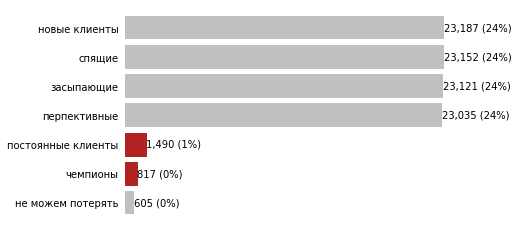

In [47]:
# считаем клиентв и визуализируем сегменты
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['чемпионы', 'постоянные клиенты']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                     int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [48]:
# Описываем клиентов по сегментам RM
segt_map = {
    r'11': 'спящие',
    r'1[2-3]': 'в зоне риска',
    r'14': 'не можем потерять',
    r'2[1-2]': 'засыпающие',
    r'23': 'необходимо внимание',
    r'[2-3]4': 'постоянные клиенты',
    r'31': 'перпективные',
    r'[3-4][2-3]': 'потенциальные лоялисты',
    r'41': 'новые клиенты',
    r'44': 'чемпионы'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2     1438          1    129.90  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f     1440          1     18.90  4  1  1   
2  0000f46a3911fa3c0805444483337064     1863          1     69.00  1  1  2   
3  0000f6ccb0745a6a4b88665a16c9f078     1647          1     25.99  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255     1614          1    180.00  2  1  4   

  RFM_Score                 Segment  
0       413  потенциальные лоялисты  
1       411           новые клиенты  
2       112            в зоне риска  
3       211              засыпающие  
4       214      постоянные клиенты

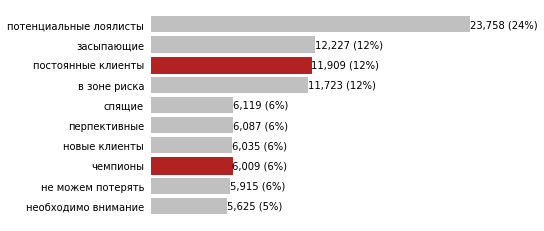

In [49]:
# считаем клиентв и визуализируем сегменты
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['чемпионы', 'постоянные клиенты']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                     int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

97% наших клиентов покупают редко. Вместе с тем всего 3 % клиентов (чемпионы + постоянные клиенты) в денежном выражении приносят нам 18%.

Необходимо провести мероприятия для перетока клиентов в сегменты: чемпионы + постоянные клиенты. 

Возможные действия:

<h6>"Спящие"</h6>
«Разбудить» их помогут:
Выгодные акции и предложения;
Подборка персональных рекомендаций.
Полезно напомнить о преимуществах. Если клиенты перестали покупать недавно, также спросите причину.

<h6>"В зоне риска/Не можем потерять"</h6>
Для более перспективных, чем спящие, можно постараться больше, чтобы их вернуть. Ведь они покупали много раз и / или на большую сумму.
Что их может заинтересовать?
Скидка или купон на покупку, информация о распродаже;
Персональная товарная подборка;
Полезные видео или статьи (как в примере ниже).
И обязательно спросите причину, по которой они перестали у вас покупать.

<h6>"Новые клиенты"</h6>
Постарайтесь их перевести в ряды лояльных. Для этого поделитесь другим полезным контентом (обзоры, статьи, руководства). 
Можно смело приглашать их в группы соцсетей и на мероприятия. Там удобнее всего будет ответить на их вопросы и объяснить, почему ваш продукт им подходит.

<h6>"Перспективные"</h6>
Выясните с помощью опроса, доволен ли он, какие у него пожелания. И другую информацию, которая пригодится для удержания: что ему интересно, какие у него потребности.
Будьте аккуратны со скидками. У таких клиентов все шансы стать постоянными покупателями по полной стоимости. Поэтому лучше мотивировать чем-то другим. Например — шанс получить подарок в обмен на отзыв.

<h6>"Чемпионы"</h6>
Важно убедить этих клиентов в том, что вы их цените. Попросите оставить отзыв и сообщите о персональном обслуживании. 
Скидки для этих клиентов противопоказаны! Ваша цель — мотивировать их на дальнейшие регулярные покупки. Подайте идеи в персональной товарной подборке или, если это инфопродукт, напомните о продлении подписки.
Не стоит утомлять лишними коммуникациями тех, кто итак покупает. Сообщайте только самую важную информацию и предложения «для любимых клиентов».
